# Fitting machine learning models to predict presence of cardiovascular disease

From the DataFrame obtained after the data exploration process, we can use it to fit models for predicting presence of cardiovascular disease. Here, we are testing using the following models:
- Logistic Regression
- Decision Tree Classifier
- Random Forest Classifier

## Initial steps

### Imports

In [1]:
import os
from random import randint

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier

### Initializations

In [2]:
# Setting seed for random sampling
seed = randint(0, 2 ** 32 - 1)
# seed = 55886695 # Choose this seed to recreate previous models and to keep our conclusions consistent
print("Current seed: {}".format(seed))

# Setting seaborn theme
sb.set_theme(font_scale=2)

Current seed: 1289308838


## Retrieving DataFrame from .pkl file

In [3]:
data = pd.read_pickle(os.path.join("data","data_explore.pkl"))
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                                      Non-Null Count  Dtype
---  ------                                      --------------  -----
 0   hasHeartDisease                             1000 non-null   bool 
 1   restingBP                                   1000 non-null   int64
 2   noofmajorvessels                            1000 non-null   int64
 3   fastingbloodsugar                           1000 non-null   bool 
 4   chestpain_TypicalAngina                     1000 non-null   bool 
 5   chestpain_AtypicalAngina                    1000 non-null   bool 
 6   chestpain_NonAnginal                        1000 non-null   bool 
 7   chestpain_Asymptomatic                      1000 non-null   bool 
 8   restingrelectro_LeftVentricularHypertrophy  1000 non-null   bool 
 9   slope_Undefined                             1000 non-null   bool 
 10  slope_Upsloping                      

## Creating helper class and variables for storing column names

This is to avoid misspellings and ease of coding when combined with code suggestions.

### Helper class *Column*

Used for storing names of all columns in dataset, helps avoids misspelling key values.

Note: Elements starting with "N" are for numerical columns, while "B" are for boolean columns. (Categorical columns were split through one-hot encoding into boolean columns.)

In [4]:
class Column:
    # Numeric columns
    N_RESTING_BP = "restingBP"
    N_MAJOR_VESSELS_CNT = "noofmajorvessels"
    
    # Boolean columns
    B_IS_FASTING_BLOOD_SUGAR = "fastingbloodsugar"
    
    B_RRE_LEFT_HYPERTROPHY = "restingrelectro_LeftVentricularHypertrophy"
    
    B_CHESTPAIN_TYPICALANGINA = "chestpain_TypicalAngina"
    B_CHESTPAIN_ATYPICALANGINA = "chestpain_AtypicalAngina"
    B_CHESTPAIN_NONANGINAL = "chestpain_NonAnginal"
    B_CHESTPAIN_ASYMPTOMATIC = "chestpain_Asymptomatic"
    
    B_SLOPE_UNDEFINED = "slope_Undefined"
    B_SLOPE_UP = "slope_Upsloping"
    B_SLOPE_FLAT = "slope_Flat"
    B_SLOPE_DOWN = "slope_Downsloping"
    
    # Response Variable
    B_HAS_HEART_DISEASE = "hasHeartDisease"

### Helper variables

The following variables (of type *list*) are for grouping Column names with respect to their data types (Numerical vs Boolean/Categorical) and purposes (Predictor vs Response variable).

In [5]:
# for key in Column.__dict__:
#     print(f"Column.{key},")

col_num = [
    Column.N_RESTING_BP,
    Column.N_MAJOR_VESSELS_CNT
]

col_cat = [
    Column.B_IS_FASTING_BLOOD_SUGAR,
    Column.B_RRE_LEFT_HYPERTROPHY,
    Column.B_SLOPE_UNDEFINED,
    Column.B_CHESTPAIN_TYPICALANGINA,
    Column.B_CHESTPAIN_ATYPICALANGINA,
    Column.B_CHESTPAIN_NONANGINAL,
    Column.B_CHESTPAIN_ASYMPTOMATIC,
    Column.B_SLOPE_UP,
    Column.B_SLOPE_DOWN,
    Column.B_SLOPE_FLAT,
]

col_pred = col_num + col_cat
col_target = Column.B_HAS_HEART_DISEASE

## Helper functions

For the following purposes:
- Displaying the results of the model through its prediction accuracy (based on the confusion matrix)
- Defining a universal template for the model's performance statistics
- Clarity of code and ease of coding

In [6]:
def display_confusion_matrix(
    cnf_matrix: np.ndarray[2,2],
    figsize: tuple[int,int] = (16,16),
    title: str = "Predicting presence of heart disease"
) -> None:
    '''
    Displays the model confusion matrix through seaborn heatmap
    
    :param cnf_matrix: A 2 by 2 confusion matrix for comparing predicted vs actual values
    "param (int, int) figsize: Dimensions of the displayed figure, defaults to (16,16)
    :param str title: Title of the plot, defaults to "Predicting presence of heart disease"
    '''
    
    f = plt.figure(figsize=figsize)
    sb.heatmap(cnf_matrix, annot=True, fmt='g')

    plt.title(title)
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")

In [7]:
def print_model_statistics(cnf_matrix: np.ndarray[2,2]) -> None:
    '''
    Prints a summary of the model statistics (TPR, FPR, TNR, FNR and Model Accuracy)
    
    :param cnf_matrix: A 2 by 2 confusion matrix for comparing predicted vs actual values
    '''
    
    neg_cnt = sum(cnf_matrix[0])
    tnr = (cnf_matrix[0][0] / neg_cnt)*100
    fpr = (cnf_matrix[0][1] / neg_cnt)*100
    
    pos_cnt = sum(cnf_matrix[1])
    tpr = (cnf_matrix[1][1] / pos_cnt)*100
    fnr = (cnf_matrix[1][0] / pos_cnt)*100

    test_size = (pos_cnt + neg_cnt)
    acc = ((cnf_matrix[0][0] + cnf_matrix[1][1]) / test_size)*100
    precision = (cnf_matrix[0][0]/(cnf_matrix[0][0]+cnf_matrix[0][1]))*100

    print(f"Test size: {test_size}")
    print("Model accuracy: {:.5f}%".format(acc))
    print("Model Precision: {:5f}%".format(precision))
    print('\n', "=" * 50, '\n', sep ='')
    print(f"Negative Count: {neg_cnt}")
    print("False Negative Rate (FNR): \t{:.5f}%".format(fnr))
    print("True Negative Rate (TNR): \t{:.5f}%".format(tnr))
    print('\n', "=" * 50, '\n', sep ='')
    print(f"Positive Count: {pos_cnt}")
    print("False Positive Rate (FPR): \t{:.5f}%".format(fpr))
    print("True Positive Rate (TPR): \t{:.5f}%".format(tpr))

## Fitting models

### Splitting original dataset into train and test sets

In [8]:
x_train, x_test, y_train, y_test = train_test_split(data[col_pred], data[col_target], test_size=0.3, random_state=seed)

### Logistic regression model
Logistic regression estimates the possibility based on the data to make predictions.

#### Fitting model

In [9]:
log_reg = LogisticRegression(random_state=seed)

log_reg.fit(x_train, y_train)

c:\Users\BAOHUY\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=1289308838)

#### Performance of model

Test size: 300
Model accuracy: 94.33333%
Model Precision: 94.354839%


Negative Count: 124
False Negative Rate (FNR): 	5.68182%
True Negative Rate (TNR): 	94.35484%


Positive Count: 176
False Positive Rate (FPR): 	5.64516%
True Positive Rate (TPR): 	94.31818%


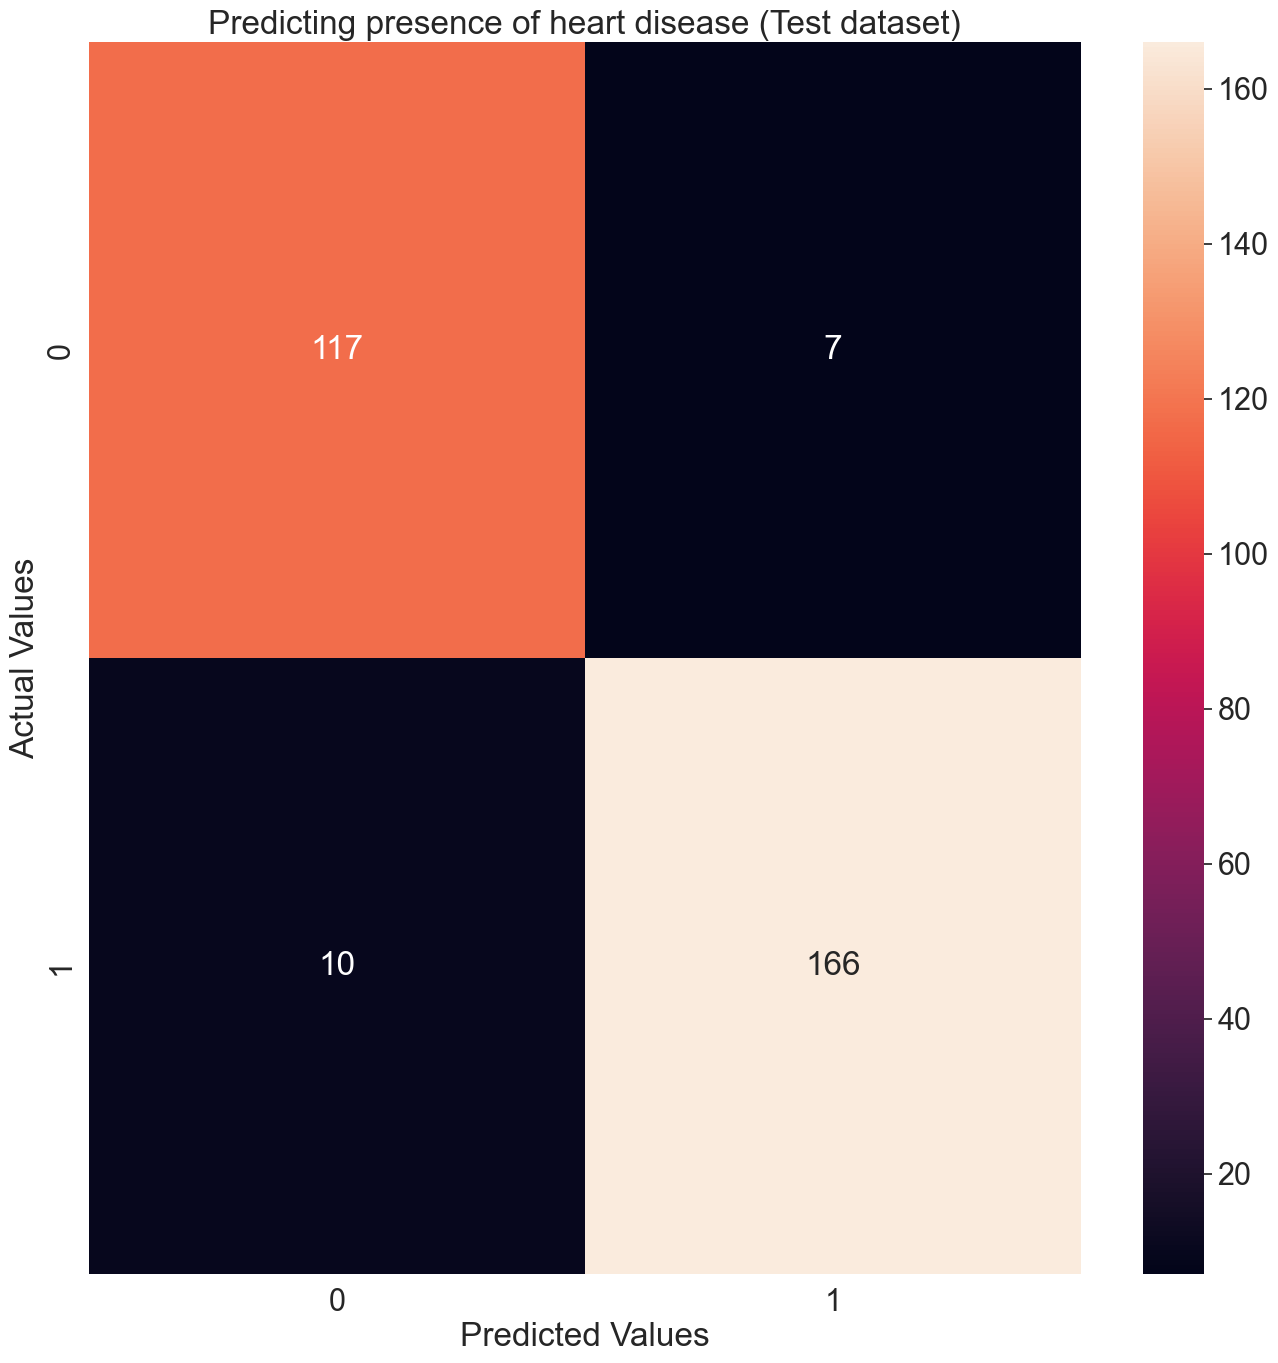

In [10]:
y_pred_log_reg = log_reg.predict(x_test)

cnf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)

display_confusion_matrix(cnf_matrix_log_reg, title="Predicting presence of heart disease (Test dataset)")
print_model_statistics(cnf_matrix_log_reg)

#### Analysis of model's performance
According to the confusion matrix above, the logistic regression model predicted the presence of heart disease correctly which gives us a high model accuracy. The precision of the model is also very high. Therefore, logistic regression is a good model in predicting heart diseases. 

### Decision Tree model
Decision tree considers all the possible feature splits with random and uncorrelated data

#### Fitting model

In [11]:
dec_tree = DecisionTreeClassifier(max_depth=5, random_state=seed)

dec_tree.fit(x_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=1289308838)

#### Display Decision Tree

[Text(0.5, 0.9166666666666666, 'slope_Flat <= 0.5\ngini = 0.488\nsamples = 700\nvalue = [296, 404]\nclass = False'),
 Text(0.3409090909090909, 0.75, 'slope_Downsloping <= 0.5\ngini = 0.471\nsamples = 462\nvalue = [287, 175]\nclass = True'),
 Text(0.29545454545454547, 0.5833333333333334, 'restingBP <= 159.0\ngini = 0.249\nsamples = 336\nvalue = [287, 49]\nclass = True'),
 Text(0.18181818181818182, 0.4166666666666667, 'chestpain_NonAnginal <= 0.5\ngini = 0.094\nsamples = 264\nvalue = [251, 13]\nclass = True'),
 Text(0.09090909090909091, 0.25, 'restingrelectro_LeftVentricularHypertrophy <= 0.5\ngini = 0.049\nsamples = 238\nvalue = [232, 6]\nclass = True'),
 Text(0.045454545454545456, 0.08333333333333333, 'gini = 0.026\nsamples = 230\nvalue = [227, 3]\nclass = True'),
 Text(0.13636363636363635, 0.08333333333333333, 'gini = 0.469\nsamples = 8\nvalue = [5, 3]\nclass = True'),
 Text(0.2727272727272727, 0.25, 'restingBP <= 130.0\ngini = 0.393\nsamples = 26\nvalue = [19, 7]\nclass = True'),
 Te

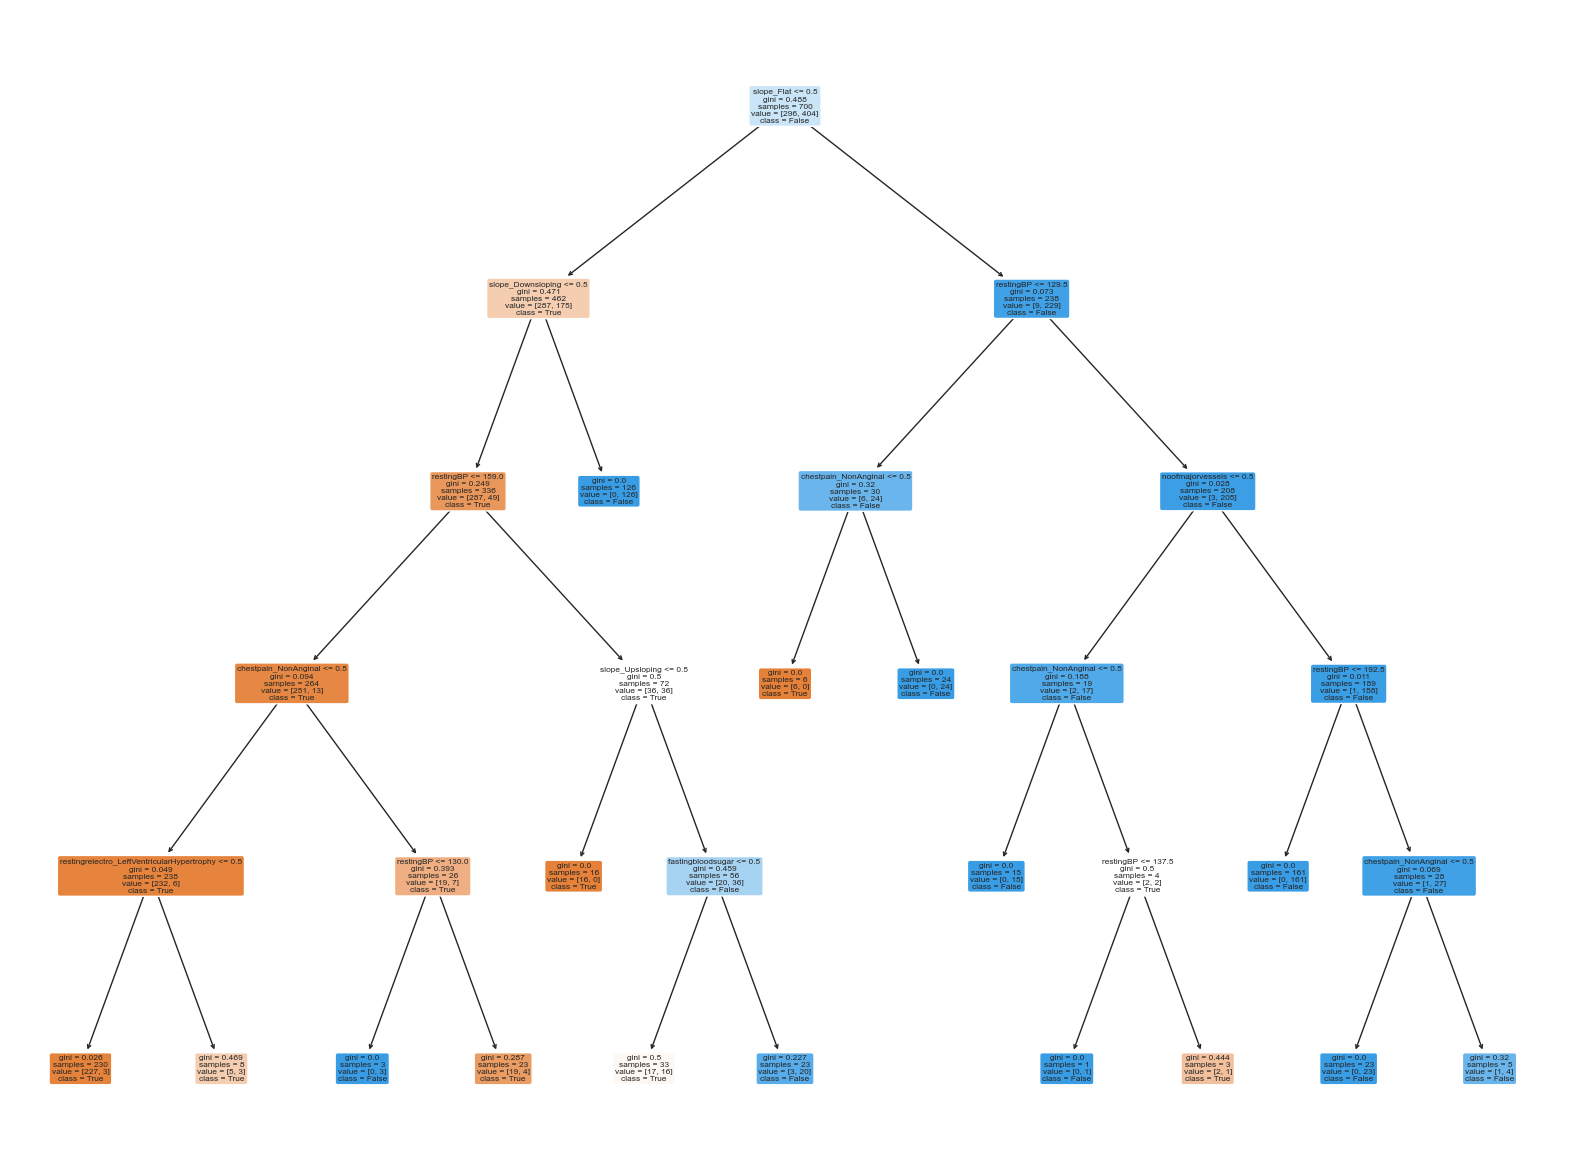

In [12]:
f = plt.figure(figsize=(20,15))
plot_tree(
    dec_tree, filled=True, rounded=True,
    fontsize=6,
    feature_names=col_pred,
    class_names=["True", "False"]
)

#### Performance of model

Test size: 300
Model accuracy: 92.33333%
Model Precision: 95.161290%


Negative Count: 124
False Negative Rate (FNR): 	9.65909%
True Negative Rate (TNR): 	95.16129%


Positive Count: 176
False Positive Rate (FPR): 	4.83871%
True Positive Rate (TPR): 	90.34091%


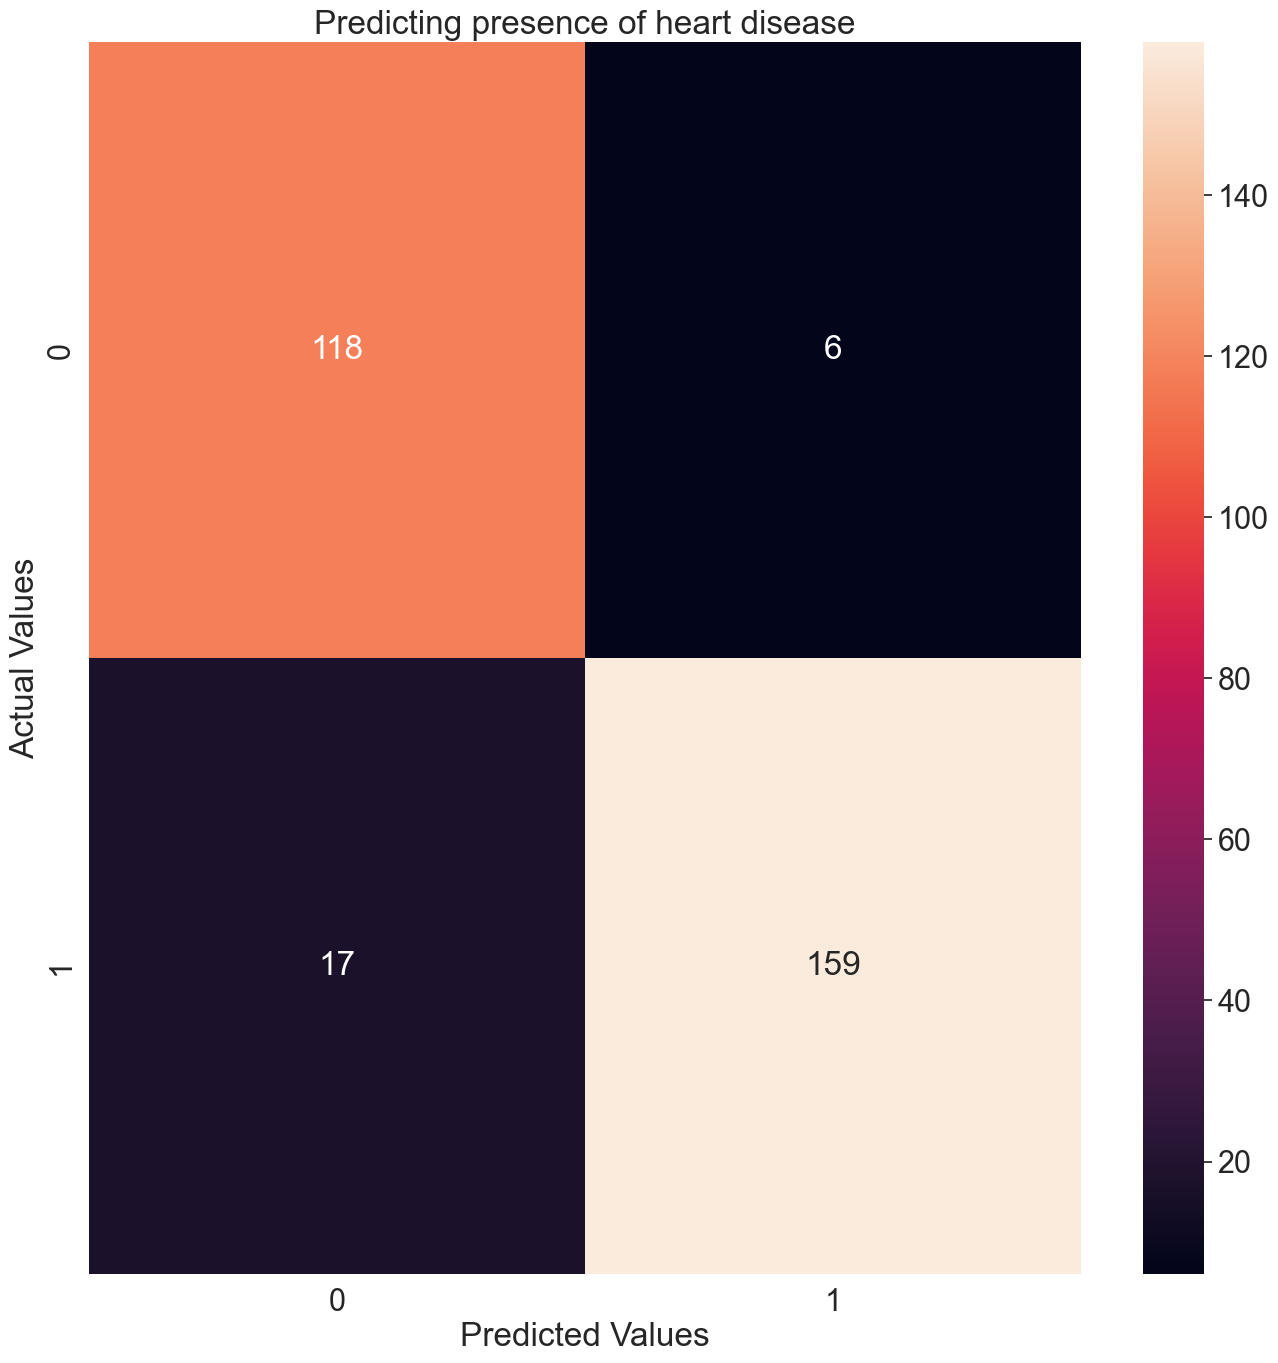

In [13]:
y_pred_dec_tree = dec_tree.predict(x_test)

cnf_matrix_dec_tree = confusion_matrix(y_test, y_pred_dec_tree)

display_confusion_matrix(cnf_matrix_dec_tree)
print_model_statistics(cnf_matrix_dec_tree)

#### Analysis of model's performance
According to the confusion matrix above, the decision tree predicted the presence of heart disease correctly which gives us a high model accuracy. The precision of the model is also relatively high. Therefore, decision tree is a good model in predicting heart diseases. However, after comparing with the logistic regression model, the logistic model is a more suitable model to predict heart disease as it has a higher model accuracy than the decision tree.

### Random Forest Model
It is a model derived from the decision tree where it takes a random subset of features, which ensures low correlation among decision trees.

#### Fitting Model

In [14]:
rforest = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=seed)

rforest.fit(x_train, y_train)

RandomForestClassifier(max_depth=5, random_state=1289308838)

#### Performance of Model

Test size: 300
Model accuracy: 96.00000%
Model Precision: 93.548387%


Negative Count: 124
False Negative Rate (FNR): 	2.27273%
True Negative Rate (TNR): 	93.54839%


Positive Count: 176
False Positive Rate (FPR): 	6.45161%
True Positive Rate (TPR): 	97.72727%


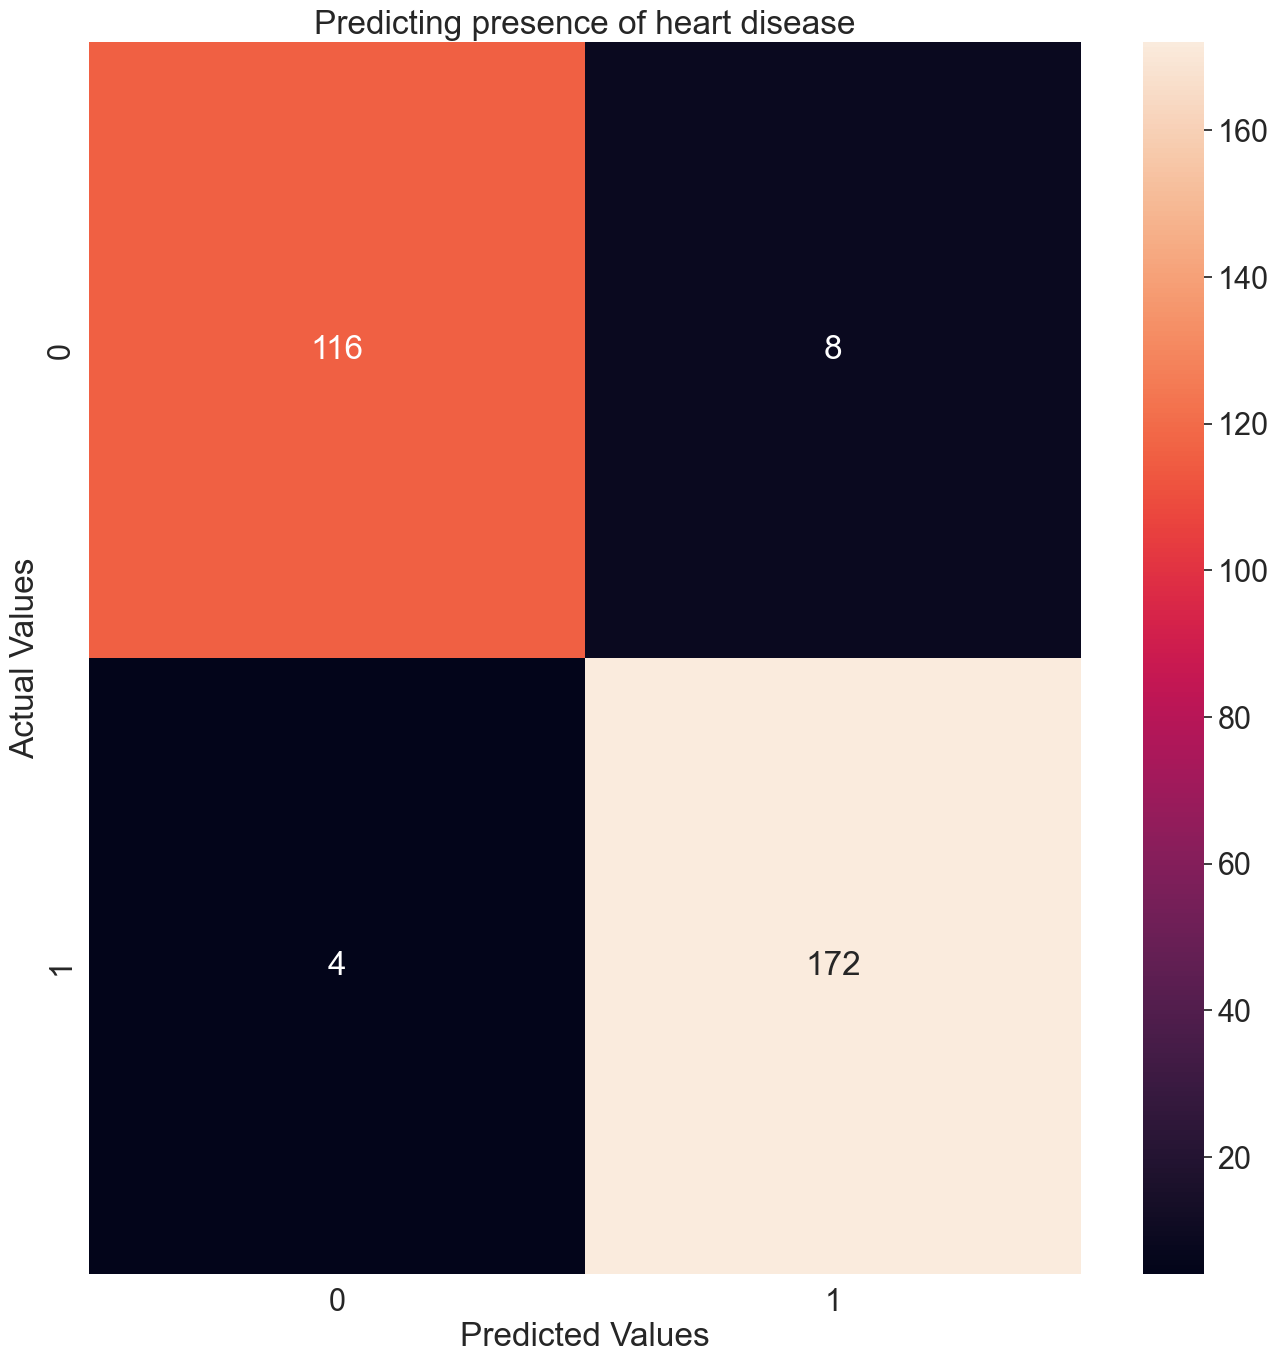

In [15]:
y_pred_rforest = rforest.predict(x_test)

cnf_matrix_rforest = confusion_matrix(y_test, y_pred_rforest)

display_confusion_matrix(cnf_matrix_rforest)
print_model_statistics(cnf_matrix_rforest)

#### Optimizing parameters for random forest classifier

In [16]:
param_grid = {
    'n_estimators': np.arange(100,1001,100),
    'max_depth': np.arange(4, 11),
}

hpGrid = GridSearchCV(
    RandomForestClassifier(random_state=seed),
    param_grid,
    cv = 5,
    scoring = 'accuracy',
)

hpGrid.fit(x_train, y_train)

best_rforest = hpGrid.best_estimator_
best_rforest

RandomForestClassifier(max_depth=8, n_estimators=400, random_state=1289308838)

#### Performance of optimized model

Test size: 300
Model accuracy: 96.00000%
Model Precision: 94.354839%


Negative Count: 124
False Negative Rate (FNR): 	2.84091%
True Negative Rate (TNR): 	94.35484%


Positive Count: 176
False Positive Rate (FPR): 	5.64516%
True Positive Rate (TPR): 	97.15909%


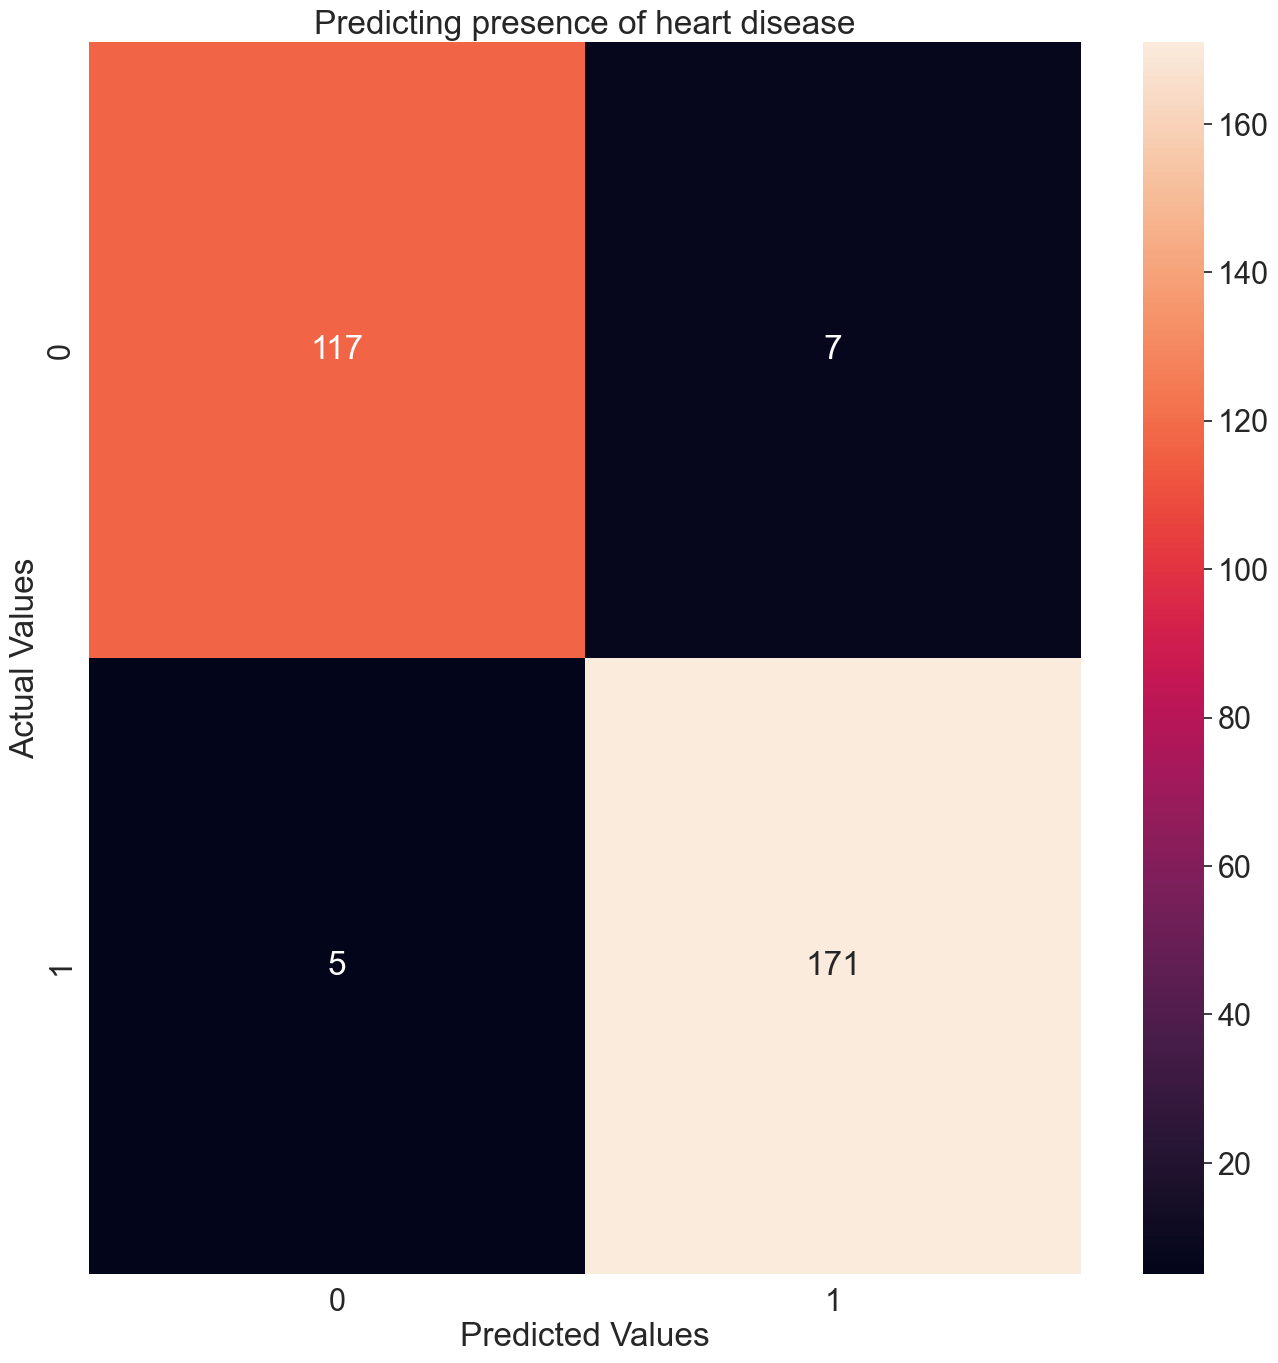

In [17]:
y_pred_best_rforest = best_rforest.predict(x_test)

cnf_matrix_best_rforest = confusion_matrix(y_test, y_pred_best_rforest)

display_confusion_matrix(cnf_matrix_best_rforest)
print_model_statistics(cnf_matrix_best_rforest)

#### Analysis of model's performance

According to the optimised confusion matrix above, the random forest classifier predicted the presence of heart disease correctly which gives us a high model accuracy. The precision of the model is also very high. Therefore, the random forest classifier is a good model in predicting heart diseases. Even after comparing with the supposed better model, logistic regression, the Random Forest Classifier is still better 

## Reflection

### Summary of each models performance

In [18]:
print("Logistic Regression model\n")
print_model_statistics(cnf_matrix_log_reg)
print('\n', '*' * 50, '\n', sep='')

print("Decision Tree Classifier model\n")
print_model_statistics(cnf_matrix_dec_tree)
print('\n', '*' * 50, '\n', sep='')

print("Random Forest Classifier model\n")
print_model_statistics(cnf_matrix_best_rforest)
print('\n', '*' * 50, '\n', sep='')

Logistic Regression model

Test size: 300
Model accuracy: 94.33333%
Model Precision: 94.354839%


Negative Count: 124
False Negative Rate (FNR): 	5.68182%
True Negative Rate (TNR): 	94.35484%


Positive Count: 176
False Positive Rate (FPR): 	5.64516%
True Positive Rate (TPR): 	94.31818%

**************************************************

Decision Tree Classifier model

Test size: 300
Model accuracy: 92.33333%
Model Precision: 95.161290%


Negative Count: 124
False Negative Rate (FNR): 	9.65909%
True Negative Rate (TNR): 	95.16129%


Positive Count: 176
False Positive Rate (FPR): 	4.83871%
True Positive Rate (TPR): 	90.34091%

**************************************************

Random Forest Classifier model

Test size: 300
Model accuracy: 96.00000%
Model Precision: 94.354839%


Negative Count: 124
False Negative Rate (FNR): 	2.84091%
True Negative Rate (TNR): 	94.35484%


Positive Count: 176
False Positive Rate (FPR): 	5.64516%
True Positive Rate (TPR): 	97.15909%

*******************

### Conclusion


The best model to predict heart disease is the Random Forest Classifier. 

According to our findings, even though all models are good at correctly predicting the presence of heart disease, the most accurate model is the random forest classifier model where it has the highest accuracy and precision. By its operational nature, it is also very efficient. 